#  1.Initial Setup, Kaggle Connection, and Dat Download

In [ ]:


from google.colab import drive
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET_SIZE = (96, 96)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
BATCH_SIZE = 64
EPOCHS_PHASE_1 = 20
EPOCHS_PHASE_2 = 10
LEARNING_RATE_PHASE_1 = 0.001
LEARNING_RATE_PHASE_2 = 0.0001

KAGGLE_CREDENTIALS_PATH = "/content/drive/MyDrive/Kaggle/kaggle.json"
KAGGLE_DATASET_ID = "gti-upm/leapgestrecog"

DOWNLOAD_DIR = "/content/leap_gesture_data"

DATA_ROOT_PATH_RAW_BASE = os.path.join(DOWNLOAD_DIR, 'leapgestrecog')
FIXED_ROOT_PATH = '/content/leap_gesture_data/fixed_data'
MODEL_SAVE_PATH = "/content/drive/MyDrive/Kaggle_Gesture_Dataset/best_resnet50_leap_model.h5"

if os.path.exists(DOWNLOAD_DIR):
    shutil.rmtree(DOWNLOAD_DIR)
    print(f"Removed previous data directory: {DOWNLOAD_DIR}")
if os.path.exists(FIXED_ROOT_PATH):
    shutil.rmtree(FIXED_ROOT_PATH)
    print(f"Removed previous fixed directory: {FIXED_ROOT_PATH}")

drive.mount('/content/drive')
print("\n--- Setting up Kaggle API and downloading data ---")

!pip install -q kaggle

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

try:
    shutil.copy(KAGGLE_CREDENTIALS_PATH, "/root/.kaggle/kaggle.json")
    os.chmod("/root/.kaggle/kaggle.json", 0o600)
    print("Kaggle API key configured successfully.")
except FileNotFoundError:
    print(f"FATAL ERROR: Kaggle key not found at {KAGGLE_CREDENTIALS_PATH}. Please check the path.")
    exit()

os.makedirs(DOWNLOAD_DIR)
print("Downloading dataset...")
!kaggle datasets download -d {KAGGLE_DATASET_ID} -p {DOWNLOAD_DIR} --unzip
print(f"Dataset downloaded and unzipped to {DOWNLOAD_DIR}")

Mounted at /content/drive

--- Setting up Kaggle API and downloading data ---
Kaggle API key configured successfully.
Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 97% 2.06G/2.13G [00:20<00:00, 144MB/s]
100% 2.13G/2.13G [00:20<00:00, 111MB/s]
Dataset downloaded and unzipped to /content/leap_gesture_data


# 2. Defining the Correct Path and Comprehensive Restructuring


In [ ]:


print("\n--- Starting robust data reorganization to ensure all 20,000 files are moved ---")


DATA_ROOT_PATH_FINAL = os.path.join(DATA_ROOT_PATH_RAW_BASE, 'leapGestRecog')

if not os.path.exists(DATA_ROOT_PATH_FINAL):
    print("CRITICAL: Final raw data path not found. Please check manually!")

    DATA_ROOT_PATH_FINAL = DATA_ROOT_PATH_RAW_BASE
else:
    print(f"Using confirmed raw data path: {DATA_ROOT_PATH_FINAL}")

if not os.path.exists(FIXED_ROOT_PATH):
    os.makedirs(FIXED_ROOT_PATH)

files_moved_count = 0

for subject_folder in os.listdir(DATA_ROOT_PATH_FINAL):
    subject_path = os.path.join(DATA_ROOT_PATH_FINAL, subject_folder)

    if os.path.isdir(subject_path) and subject_folder.isdigit():

        for gesture_folder in os.listdir(subject_path):
            source_gesture_path = os.path.join(subject_path, gesture_folder)

            if os.path.isdir(source_gesture_path):
                destination_path = os.path.join(FIXED_ROOT_PATH, gesture_folder)

                if not os.path.exists(destination_path):
                    os.makedirs(destination_path)

                for filename in os.listdir(source_gesture_path):
                    if filename.endswith('.png'):
                        shutil.move(os.path.join(source_gesture_path, filename), destination_path)
                        files_moved_count += 1


print(f"Data reorganization complete. Total files moved: {files_moved_count}")

print(f"\n--- Final verification of file count ---")
total_files = !find {FIXED_ROOT_PATH} -type f -name "*.png" | wc -l
try:
    total_files_count = int(total_files[0].strip())
    print(f"TOTAL FINAL PNG FILES FOUND: {total_files_count}")

    if total_files_count < 20000:
        print("CRITICAL WARNING: Files are missing. Expected 20,000. Proceed with caution.")
    else:
        print("SUCCESS: File count is correct (20,000 files expected).")

except:
    print("Could not count files automatically.")


--- Starting robust data reorganization to ensure all 20,000 files are moved ---
Using confirmed raw data path: /content/leap_gesture_data/leapgestrecog/leapGestRecog
Data reorganization complete. Total files moved: 20000

--- Final verification of file count ---
TOTAL FINAL PNG FILES FOUND: 20000
SUCCESS: File count is correct (20,000 files expected).


#  3. Data Generator Setup


In [ ]:


print("\n--- Data Preprocessing and Generator Setup ---")


def grayscale_to_rgb(x):

    return tf.concat([x, x, x], axis=-1)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range = 0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)


train_generator = datagen.flow_from_directory(
    FIXED_ROOT_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    FIXED_ROOT_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

NUM_CLASSES = train_generator.num_classes
print(f"Number of Gesture Classes detected: {NUM_CLASSES}")


--- Data Preprocessing and Generator Setup ---
Found 18000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Number of Gesture Classes detected: 10


#  4. Build ResNet Model


In [ ]:


print("\n--- Building ResNet50 Model (Transfer Learning Setup) ---")


def build_resnet_transfer_model_for_leap(num_classes):
    input_tensor = Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1))
    rgb_like_output = Lambda(grayscale_to_rgb,
                             output_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))(input_tensor)


    resnet_base = ResNet50(weights='imagenet',
                           include_top=False,
                           input_tensor=rgb_like_output,
                           name='resnet_base_model')

    resnet_base.trainable = False


    x = resnet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax', name='predictions')(x)

    return Model(inputs=input_tensor, outputs=output)

resnet_transfer_model = build_resnet_transfer_model_for_leap(NUM_CLASSES)
print("Model built successfully with frozen ResNet base.")


--- Building ResNet50 Model (Transfer Learning Setup) ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Model built successfully with frozen ResNet base.


# 5. Initial Training (Phase 1: Classification Head Training)


In [ ]:

callbacks_phase1 = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),

    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1),

    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max')
]

resnet_transfer_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE_1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Phase 1: Training Classification Head ---")
history_phase1 = resnet_transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_PHASE_1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_phase1
)


--- Starting Phase 1: Training Classification Head ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.1739 - loss: 2.2731

281/281 ━━━━━━━━━━━━━━━━━━━━ 98s 302ms/step - accuracy: 0.1741 - loss: 2.2726 - val_accuracy: 0.3347 - val_loss: 1.9287 - learning_rate: 0.0010
Epoch 2/20
  1/281 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.4062 - loss: 1.8964

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4062 - loss: 1.8964 - val_accuracy: 0.3301 - val_loss: 1.9253 - learning_rate: 0.0010
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3823 - loss: 1.8177

281/281 ━━━━━━━━━━━━━━━━━━━━ 66s 236ms/step - accuracy: 0.3824 - loss: 1.8175 - val_accuracy: 0.4733 - val_loss: 1.6215 - learning_rate: 0.0010
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3906 - loss: 1.7358 - val_accuracy: 0.4602 - val_loss: 1.6378 - learning_rate: 0.0010
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4775 - loss: 1.5547

281/281 ━━━━━━━━━━━━━━━━━━━━ 63s 223ms/step - accuracy: 0.4776 - loss: 1.5545 - val_accuracy: 0.5136 - val_loss: 1.5224 - learning_rate: 0.0010
Epoch 6/20
  1/281 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.4844 - loss: 1.5018

281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4844 - loss: 1.5018 - val_accuracy: 0.5272 - val_loss: 1.5072 - learning_rate: 0.0010
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5349 - loss: 1.3734

281/281 ━━━━━━━━━━━━━━━━━━━━ 79s 282ms/step - accuracy: 0.5350 - loss: 1.3732 - val_accuracy: 0.5474 - val_loss: 1.4136 - learning_rate: 0.0010
Epoch 8/20
  1/281 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.5625 - loss: 1.2753

281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.5625 - loss: 1.2753 - val_accuracy: 0.5509 - val_loss: 1.4047 - learning_rate: 0.0010
Epoch 9/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 289ms/step - accuracy: 0.5749 - loss: 1.2479 - val_accuracy: 0.5509 - val_loss: 1.4239 - learning_rate: 0.0010
Epoch 10/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6719 - loss: 1.1120 - val_accuracy: 0.5338 - val_loss: 1.4479 - learning_rate: 0.0010
Epoch 11/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5831 - loss: 1.1955
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


281/281 ━━━━━━━━━━━━━━━━━━━━ 78s 277ms/step - accuracy: 0.5831 - loss: 1.1954 - val_accuracy: 0.5776 - val_loss: 1.4509 - learning_rate: 0.0010
Epoch 12/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6406 - loss: 1.0052 - val_accuracy: 0.5761 - val_loss: 1.3998 - learning_rate: 5.0000e-04
Epoch 13/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6324 - loss: 1.0986

281/281 ━━━━━━━━━━━━━━━━━━━━ 66s 236ms/step - accuracy: 0.6325 - loss: 1.0986 - val_accuracy: 0.5897 - val_loss: 1.3430 - learning_rate: 5.0000e-04
Epoch 14/20
  1/281 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.5781 - loss: 1.2507

281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5781 - loss: 1.2507 - val_accuracy: 0.6149 - val_loss: 1.3231 - learning_rate: 5.0000e-04
Epoch 15/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 259ms/step - accuracy: 0.6447 - loss: 1.0463 - val_accuracy: 0.5746 - val_loss: 1.3933 - learning_rate: 5.0000e-04
Epoch 16/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6875 - loss: 1.0615 - val_accuracy: 0.5897 - val_loss: 1.3981 - learning_rate: 5.0000e-04
Epoch 17/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6530 - loss: 1.0287

281/281 ━━━━━━━━━━━━━━━━━━━━ 61s 218ms/step - accuracy: 0.6530 - loss: 1.0287 - val_accuracy: 0.6290 - val_loss: 1.2980 - learning_rate: 5.0000e-04
Epoch 18/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6406 - loss: 1.0793 - val_accuracy: 0.6018 - val_loss: 1.3611 - learning_rate: 5.0000e-04
Epoch 19/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 60s 215ms/step - accuracy: 0.6637 - loss: 0.9986 - val_accuracy: 0.6094 - val_loss: 1.3800 - learning_rate: 5.0000e-04
Epoch 20/20
  1/281 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.5781 - loss: 1.0922
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5781 - loss: 1.0922 - val_accuracy: 0.6038 - val_loss: 1.3631 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 17.


# 6.  Performance Optimization (Phase 2: Fine-Tuning)


In [ ]:

def grayscale_to_rgb(x):
    return tf.concat([x, x, x], axis=-1)

print("\nLoading best model from Phase 1...")
resnet_transfer_model = tf.keras.models.load_model(
    MODEL_SAVE_PATH,
    custom_objects={'grayscale_to_rgb': grayscale_to_rgb}
)


for layer in resnet_transfer_model.layers:
    layer.trainable = True


RESNET_START_INDEX = 2
fine_tune_at_resnet_layers = 140
freeze_until_index = RESNET_START_INDEX + fine_tune_at_resnet_layers

frozen_count = 0
for i in range(RESNET_START_INDEX, freeze_until_index):
    if i < len(resnet_transfer_model.layers):
        layer = resnet_transfer_model.layers[i]
        layer.trainable = False
        frozen_count += 1

print(f"Total layers unfrozen for Fine-Tuning (ResNet upper layers + Classification Head): {len(resnet_transfer_model.layers) - frozen_count}")
print(f"Frozen {frozen_count} ResNet layers (indices 2 to {freeze_until_index - 1}).")

total_epochs = EPOCHS_PHASE_1 + EPOCHS_PHASE_2

callbacks_phase2 = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001, verbose=1),
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max')
]

resnet_transfer_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE_2),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n--- Starting Phase 2: Fine-Tuning (Training upper {len(resnet_transfer_model.layers) - frozen_count} layers) ---")

history_fine = resnet_transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history_phase1.epoch[-1],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_phase2
)


Loading best model from Phase 1...


Total layers unfrozen for Fine-Tuning (ResNet upper layers + Classification Head): 40
Frozen 140 ResNet layers (indices 2 to 141).

--- Starting Phase 2: Fine-Tuning (Training upper 40 layers) ---
Epoch 20/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5802 - loss: 4.1100

281/281 ━━━━━━━━━━━━━━━━━━━━ 97s 267ms/step - accuracy: 0.5807 - loss: 4.1007 - val_accuracy: 0.7016 - val_loss: 1.1487 - learning_rate: 1.0000e-04
Epoch 21/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7812 - loss: 0.5935 - val_accuracy: 0.7001 - val_loss: 1.2884 - learning_rate: 1.0000e-04
Epoch 22/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8214 - loss: 0.5215
Epoch 22: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
281/281 ━━━━━━━━━━━━━━━━━━━━ 64s 229ms/step - accuracy: 0.8215 - loss: 0.5213 - val_accuracy: 0.6426 - val_loss: 1.7057 - learning_rate: 1.0000e-04
Epoch 23/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8281 - loss: 0.3784 - val_accuracy: 0.6144 - val_loss: 1.8116 - learning_rate: 5.0000e-05
Epoch 24/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8979 - loss: 0.2943

281/281 ━━━━━━━━━━━━━━━━━━━━ 87s 310ms/step - accuracy: 0.8980 - loss: 0.2941 - val_accuracy: 0.8120 - val_loss: 0.6291 - learning_rate: 5.0000e-05
Epoch 25/30
  1/281 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.7969 - loss: 0.4338

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7969 - loss: 0.4338 - val_accuracy: 0.8226 - val_loss: 0.5704 - learning_rate: 5.0000e-05
Epoch 26/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9088 - loss: 0.2741

281/281 ━━━━━━━━━━━━━━━━━━━━ 72s 255ms/step - accuracy: 0.9089 - loss: 0.2739 - val_accuracy: 0.8468 - val_loss: 0.5725 - learning_rate: 5.0000e-05
Epoch 27/30
  1/281 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.9375 - loss: 0.1685

281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9375 - loss: 0.1685 - val_accuracy: 0.8609 - val_loss: 0.5626 - learning_rate: 5.0000e-05
Epoch 28/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 64s 227ms/step - accuracy: 0.9257 - loss: 0.2216 - val_accuracy: 0.8090 - val_loss: 0.7366 - learning_rate: 5.0000e-05
Epoch 29/30
  1/281 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9375 - loss: 0.1056
Epoch 29: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9375 - loss: 0.1056 - val_accuracy: 0.8206 - val_loss: 0.7091 - learning_rate: 5.0000e-05
Epoch 30/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 62s 222ms/step - accuracy: 0.9517 - loss: 0.1457 - val_accuracy: 0.7707 - val_loss: 1.3085 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 27.


# 7 Final Evaluation and Plotting Charts and (ROC,AUC)



--- Final Model Evaluation and Visualization  ---


Found 2000 images belonging to 10 classes.


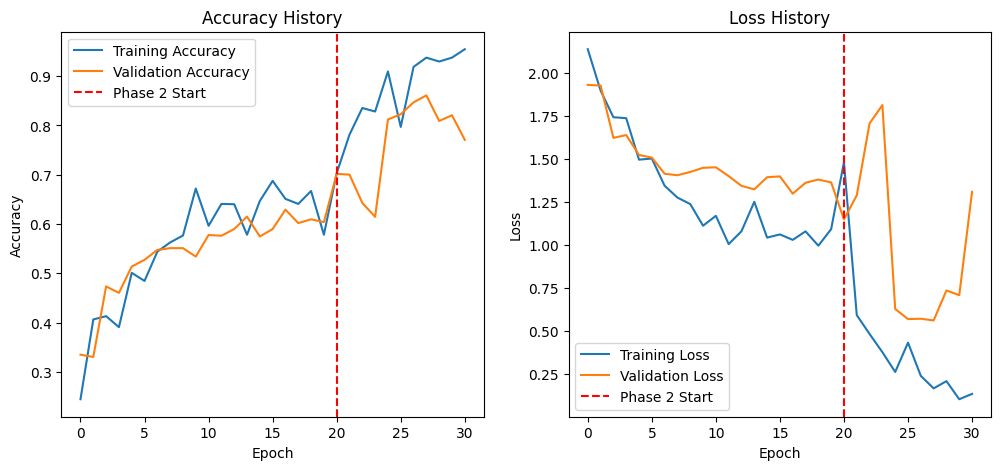


Calculating predictions using non-shuffling generator...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step

Classification Report (Precision, Recall, F1-Score) after Fine-Tuning

               precision    recall  f1-score   support

      01_palm       1.00      0.97      0.99       200
         02_l       0.86      0.83      0.84       200
      03_fist       0.90      0.81      0.86       200
04_fist_moved       1.00      0.64      0.78       200
     05_thumb       0.90      0.98      0.94       200
     06_index       0.99      0.86      0.92       200
        07_ok       0.86      1.00      0.92       200
08_palm_moved       1.00      1.00      1.00       200
         09_c       0.69      1.00      0.82       200
      10_down       0.99      0.94      0.96       200

     accuracy                           0.90      2000
    macro avg       0.92      0.90      0.90      2000
 weighted avg       0.92      0.90      0.90      2000


ROC Curve and AUC Calculation (One-vs-Rest)



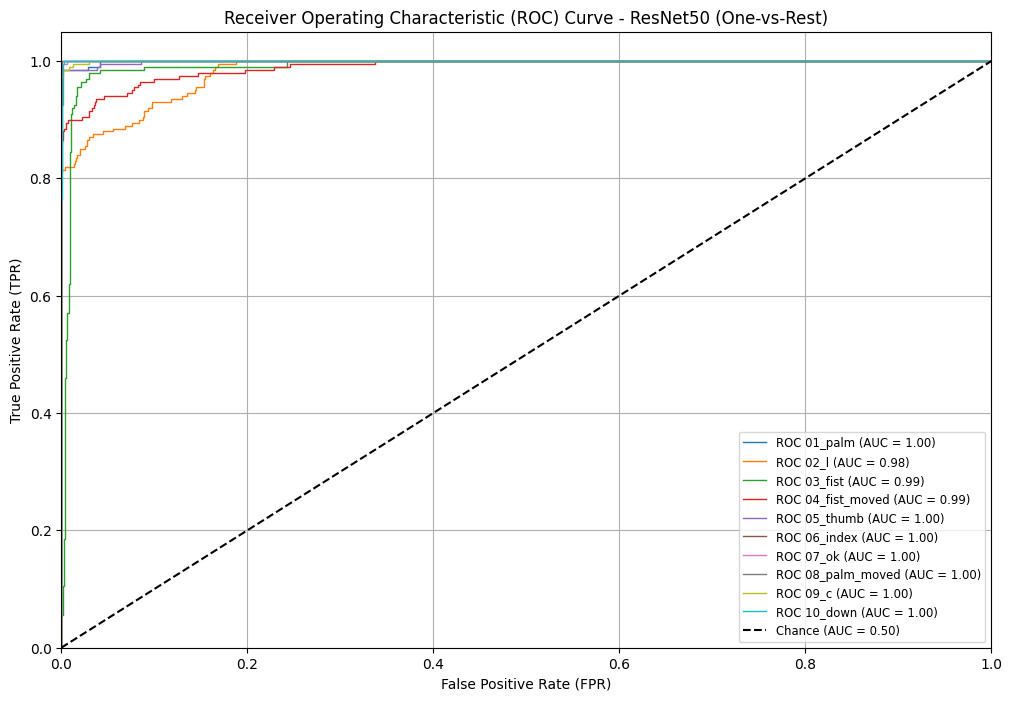

Mean AUC across all classes: 0.9962


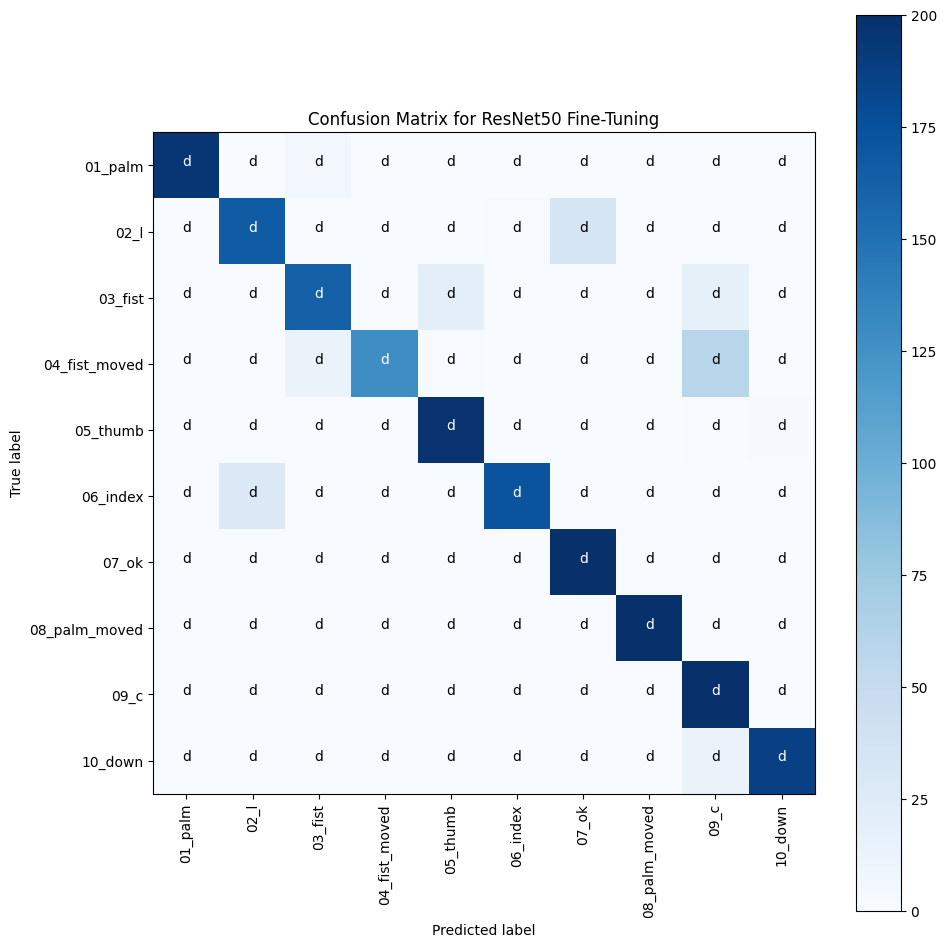

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - accuracy: 0.8765 - loss: 0.4257

--- Final Confirmed Performance Summary ---
Final Validation Accuracy (Confirmed): 90.7258%
Final Validation Loss (Confirmed): 0.3223
Best model saved to: /content/drive/MyDrive/Kaggle_Gesture_Dataset/best_resnet50_leap_model.h5


In [ ]:


import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


def grayscale_to_rgb(x):
  return tf.concat([x, x, x], axis=-1)

print("\n--- Final Model Evaluation and Visualization  ---")


final_model = tf.keras.models.load_model(
MODEL_SAVE_PATH,
custom_objects={'grayscale_to_rgb': grayscale_to_rgb}
)


eval_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

eval_generator = eval_datagen.flow_from_directory(
FIXED_ROOT_PATH,
target_size=TARGET_SIZE,
batch_size=BATCH_SIZE,
color_mode='grayscale',
class_mode='categorical',
subset='validation',
shuffle=False
)


history_combined = {}
try:
    for key in history_phase1.history.keys():
        history_combined[key] = (history_phase1.history[key] + history_fine.history[key])
except NameError:
    print("Warning: Training history (history_phase1, history_fine) not found. Skipping plot generation.")



if history_combined:
    plt.figure(figsize=(12, 5))
    epochs_range = range(len(history_combined['accuracy']))


    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_combined['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history_combined['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=EPOCHS_PHASE_1, color='r', linestyle='--', label='Phase 2 Start')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_combined['loss'], label='Training Loss')
    plt.plot(epochs_range, history_combined['val_loss'], label='Validation Loss')
    plt.axvline(x=EPOCHS_PHASE_1, color='r', linestyle='--', label='Phase 2 Start')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('accuracy_loss_history.png')
    plt.show()


eval_generator.reset()
STEP_SIZE_VALID_FULL = eval_generator.samples // eval_generator.batch_size + (eval_generator.samples % eval_generator.batch_size != 0)

print("\nCalculating predictions using non-shuffling generator...")

Y_pred = final_model.predict(eval_generator, steps=STEP_SIZE_VALID_FULL, verbose=1)
y_pred_classes = np.argmax(Y_pred, axis=1)


y_true = eval_generator.classes[0:len(y_pred_classes)]
class_names = list(eval_generator.class_indices.keys())
NUM_CLASSES = len(class_names)



print("\n" + "="*80)
print("Classification Report (Precision, Recall, F1-Score) after Fine-Tuning")
print("================================================================================\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))



print("\n" + "="*80)
print("ROC Curve and AUC Calculation (One-vs-Rest)")
print("================================================================================\n")


y_true_one_hot = to_categorical(y_true, num_classes=NUM_CLASSES)


fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(12, 8))

for i in range(NUM_CLASSES):


    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


    plt.plot(fpr[i], tpr[i], label=f'ROC {class_names[i]} (AUC = {roc_auc[i]:.2f})', linewidth=1)


plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - ResNet50 (One-vs-Rest)')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()

print(f"Mean AUC across all classes: {np.mean(list(roc_auc.values())):.4f}")



def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix for ResNet50 Fine-Tuning')
plt.savefig('confusion_matrix.png')
plt.show()


loss, accuracy = final_model.evaluate(eval_generator, steps=eval_generator.samples // BATCH_SIZE, verbose=1)

print(f"\n--- Final Confirmed Performance Summary ---")
print(f"Final Validation Accuracy (Confirmed): {accuracy * 100:.4f}%")
print(f"Final Validation Loss (Confirmed): {loss:.4f}")
print(f"Best model saved to: {MODEL_SAVE_PATH}")